In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import glob
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import toolbox
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

# create color map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255),
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# define pressure levels for interpolation
new_pressure_levels = [1., 1.21152771, 1.46779931, 1.77827942, 2.15443468, 2.61015725,    
                       3.1622777, 3.83118677, 4.64158869, 5.62341309, 6.81292057, 8.25404167, 
                       10. , 12.11527634, 14.67799282, 17.78279495, 21.54434776,   26.10157204, 
                       31.62277603,   38.31186676, 46.41588974,   56.23413086,   68.1292038 ,   
                       82.54042053, 100., 121.15276337, 146.77992249, 177.82794189, 215.44346619,  
                       261.01571655,  300.,  316.22775269, 350.,  400.,  450.,  500., 550., 600.,  
                       650.        ,  700.        , 750.        ,  775.        ,  800.        ,  
                       825.        ,850.        ,  875.        ,  900.        ,  925.        ,
                       950.        ,  975.        , 1000.        ]
    
# import temperature data (and zonal wind to remove QBO)
T_root_directory = '/home/disk/bdc2/aodhan/Zambri2020/T*1995*'
U_root_directory = '/home/disk/bdc2/aodhan/Zambri2020/U*1995*'
T_files = np.sort(glob.glob(T_root_directory))
U_files = np.sort(glob.glob(U_root_directory))


# get tropopause information from annual mean observations
def alt2pres(altitude):
    """
    Function to turn GNSS-RO derived tropopause height from Z coordinate
    to P coordinate.
    """
    
    H = 7 
    press = 1000*np.exp(-1*(altitude/H))
    return press

# turn lrz to lrp
lrz = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/tempmaps/lrz_maps_zm_annual_mean.npy')
lrp = alt2pres(lrz)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Load Data

In [2]:
# load T data
t_all_ens = []
u_all_ens = []
for file_idx, t_file in enumerate(T_files):
    xarray = xr.open_dataset(t_file).sel(time=slice('2002-01-01', '2022-12-31'))
    xarray_u = xr.open_dataset(U_files[file_idx]).sel(time=slice('2002-01-01', '2022-12-31'))
    
    # convert to pressure levels
    P0 = xarray.P0  # Reference pressure in Pa
    pressure = xarray['hyam'] * P0 + xarray['hybm'] * xarray['PS']
    xarray = xarray.assign_coords(pressure=pressure)
    standard_levels = xr.DataArray(new_pressure_levels, dims="level", name="pressure")
    xarray = xarray.interp(lev=standard_levels)  # convert hPa to Pa
    xarray_u = xarray_u.assign_coords(pressure=pressure)
    xarray_u = xarray_u.interp(lev=standard_levels)
    
    # define latitudes and levels
    lev = xarray.lev.values
    lats = xarray.lat.values
    
    # remove climatologies
    t_data = xarray.T.values
    temp_cal = np.reshape(t_data, (21,12, len(lev), len(lats)))
    temp_seasonality = np.nanmean(temp_cal, axis=0)
    temp_anoms = temp_cal - temp_seasonality
    temp_anoms_ts = np.reshape(temp_anoms, (21*12, len(lev), len(lats)))
    
    u_data = xarray_u.U.values
    u_cal = np.reshape(u_data, (21,12, len(lev), len(lats)))
    u_seasonality = np.nanmean(u_cal, axis=0)
    u_anoms = u_cal - u_seasonality
    u_anoms_ts = np.reshape(u_anoms, (21*12, len(lev), len(lats)))
    
    # create xarrays from data
    time = pd.date_range(start="2002-01-01", end="2022-12-01", freq='MS')
    t_anoms = xr.DataArray(temp_anoms_ts, coords={"time": time, "lev": lev, "lat": lats}, dims=["time", "lev", "lat"])
    u_anoms = xr.DataArray(u_anoms_ts, coords={"time": time, "lev": lev, "lat": lats}, dims=["time", "lev", "lat"])
    
    # append data
    t_all_ens.append(t_anoms)
    u_all_ens.append(u_anoms)

# get concatenated ensemble members
ens_t = xr.concat(t_all_ens, dim='ens_num')
ens_u = xr.concat(u_all_ens, dim='ens_num')

# get ensemble means
ens_t_mean = ens_t.mean(dim='ens_num')
ens_u_mean = ens_u.mean(dim='ens_num')

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


# Remove QBO and ENSO

In [3]:
# remove the interannual variability from each ensemble member and find trends
trends_all = []
temp_anoms_all = []
for ens_idx in range(10):
    
    # find ensemble member
    t_ens_data = ens_t.isel(ens_num=ens_idx)
    u_ens_data = ens_u.isel(ens_num=ens_idx)
    
    # remove ensemble mean from each ensemble memeber
    t_ens_data_mr = t_ens_data - ens_t_mean
    
    # get the internal variability
    Teq = t_ens_data_mr.sel(lat=slice(-15,15)).mean(dim='lat').values
    T500_anoms_ts = Teq[:,35]
    
    # get zonal wind at 30 hPa
    u30 = ens_u_mean.sel(lat=slice(-5,5)).mean(dim='lat').values
    u30_anoms_ts = u30[:,18]

    # get zonal wind at 10 hPa
    u10 = ens_u_mean.sel(lat=slice(-5,5)).mean(dim='lat').values
    u10_anoms_ts = u10[:,12]

    # remove the QBO and ENSO
    temp_anoms_data = toolbox.ENSO_QBO_remover(t_ens_data.values, T500_anoms_ts, u10_anoms_ts, u30_anoms_ts)

    # reorgnaize array
    temp_anoms_data = np.swapaxes(temp_anoms_data, 0,2)
    temp_anoms_data = np.swapaxes(temp_anoms_data, 1,2)
    
    # find trends
    trend_map = toolbox.annual_trend_finder(temp_anoms_data)
    trends_all.append(trend_map)
    temp_anoms_all.append(temp_anoms_data)

    
# trends for each ensemble
trends_all = np.array(trends_all)[:,:,:,0]

# ensemble mean trend
ens_mean_anom = np.nanmean(temp_anoms_all, axis=0)
mean_trend = toolbox.annual_trend_finder(ens_mean_anom)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


# Find AWLS Trend

In [4]:
# find anomalous region of AWLS in model
AWLS_trend = mean_trend[22:25,30:42,0]

# weight and find AWLS trend
lat_weights = np.cos(np.deg2rad(lats[30:42]))
AWLS_trend = np.multiply(AWLS_trend, lat_weights[np.newaxis, :])
AWLS_trend = np.reshape(AWLS_trend, (len(AWLS_trend)*12))
AWLS_trend = np.nansum(AWLS_trend)/(np.sum(lat_weights)*3)
print('WACCM AWLS Trend: ', AWLS_trend)


WACCM AWLS Trend:  0.10004092495660002


# Ensemble mean trend

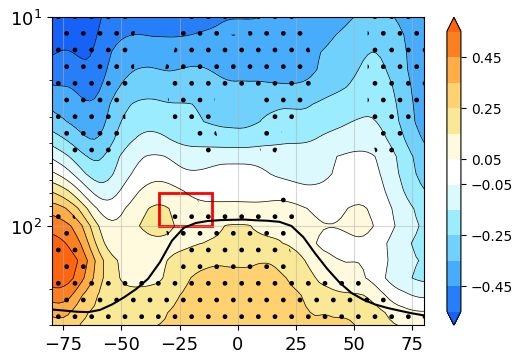

In [5]:
# define levels for plotting
levels = np.arange(-.55,.551,.1)

# set up plot size
fig, axs = plt.subplots(1, 1, figsize=(6,4))
    
# create contour plot with ensemble mean trend
plt.contour(lats, lev, mean_trend[:,:,0], levels=levels, colors='black', 
            extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
im = plt.contourf(lats, lev, mean_trend[:,:,0], levels=levels, cmap=custom_cmap, extend='both')

# plot tropopause and significance and model AWLS region
plt.plot(np.linspace(-90,90,36), lrp, color='black')
plt.contourf(lats, lev, mean_trend[:,:,1], levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
rect = patches.Rectangle((-33.75, 70.), 22.5, 30, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)

# set plotting parameters
axs.set_yscale('log')
axs.invert_yaxis()
axs.set_xlim(-80,80)
axs.set_ylim(300,10)
axs.grid(alpha=0.5)
cbar = plt.colorbar(im)
cbar.set_ticks([-0.45,-0.25, -0.05, 0.05, 0.25,0.45])
x_vals = [-75, -50, -25, 0, 25, 50, 75]
plt.xticks(x_vals)
plt.tick_params(axis='both', which='major', labelsize=13)

#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/WACCMTempEnsMean.png', dpi=300)


# Individual Circulation Regression Trends

In [6]:
# set up arrays to append to
correlation_maps = []
trends = []
circ_regr_trend = []
residual_trend = []

for ens_idx, ens_member_ts in enumerate(temp_anoms_all):
    
    # get AWLS timeseries for each simulation
    AWLS_region_data = ens_member_ts[:,22:25,30:42]
    lat_weights = np.cos(np.deg2rad(lats[30:42]))
    AWLS_region_data = np.multiply(AWLS_region_data, lat_weights[np.newaxis,np.newaxis, :])
    AWLS_region_data = np.reshape(AWLS_region_data, (len(AWLS_region_data), 3*len(lat_weights)))
    AWLS_region_ts = np.nansum(AWLS_region_data, axis=1)/(np.sum(lat_weights)*3)
    
    # get correlations
    correlation_map, significance_map = toolbox.annual_corr_finder(ens_member_ts, 
                                                                   AWLS_region_ts)
    
    # do circulation projection
    projection_timeseries, map_sig = toolbox.annual_circ_regr(ens_member_ts, 
                                                              AWLS_region_ts)
    projection_timeseries = np.swapaxes(projection_timeseries, 0,2)
    projection_timeseries = np.swapaxes(projection_timeseries, 1,2)
    residual = ens_member_ts - projection_timeseries

    #find trends
    map_of_trends = toolbox.annual_trend_finder(ens_member_ts)
    map_of_trends_projection = toolbox.annual_trend_finder(projection_timeseries)
    map_of_trends_residual = toolbox.annual_trend_finder(residual)

    # append data
    correlation_maps.append(correlation_map)
    trends.append(map_of_trends)
    circ_regr_trend.append(map_of_trends_projection)
    residual_trend.append(map_of_trends_residual)
    
    

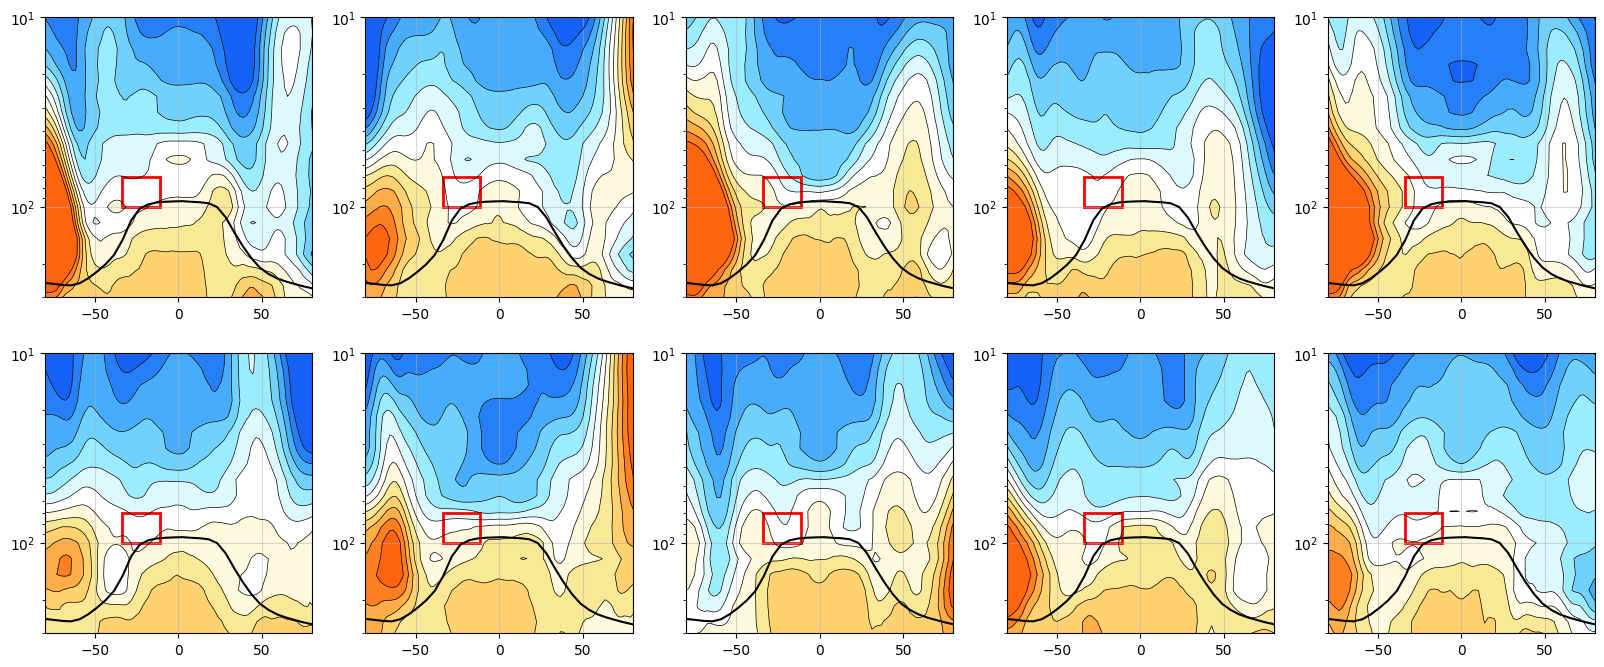

In [8]:
# define figure
fig, axs = plt.subplots(2,5, figsize=(20,8))
axes = axs.ravel()

# select plotting data
plot_trends = np.array(residual_trend)

for i in range(0, len(axes)):
    
    # select axes to plot
    ax = axes[i]
    
    # plot the trend
    ax.contour(lats, lev, plot_trends[i,:,:,0], levels=levels,colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    im = ax.contourf(lats, lev, plot_trends[i,:,:,0], levels=levels,cmap=custom_cmap, extend='both')
    
    # include lapse rate tropopause and rectangle
    ax.plot(np.linspace(-90,90,36), lrp, color='black')
    rect = patches.Rectangle((-33.75, 70.), 22.5, 30, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    # set plotting parameters
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_xlim(-80,80)
    ax.set_ylim(300,10)
    ax.grid(alpha=0.5)
    
    
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/WACCMTempAllEns.png', dpi=300)


# Correlation maps

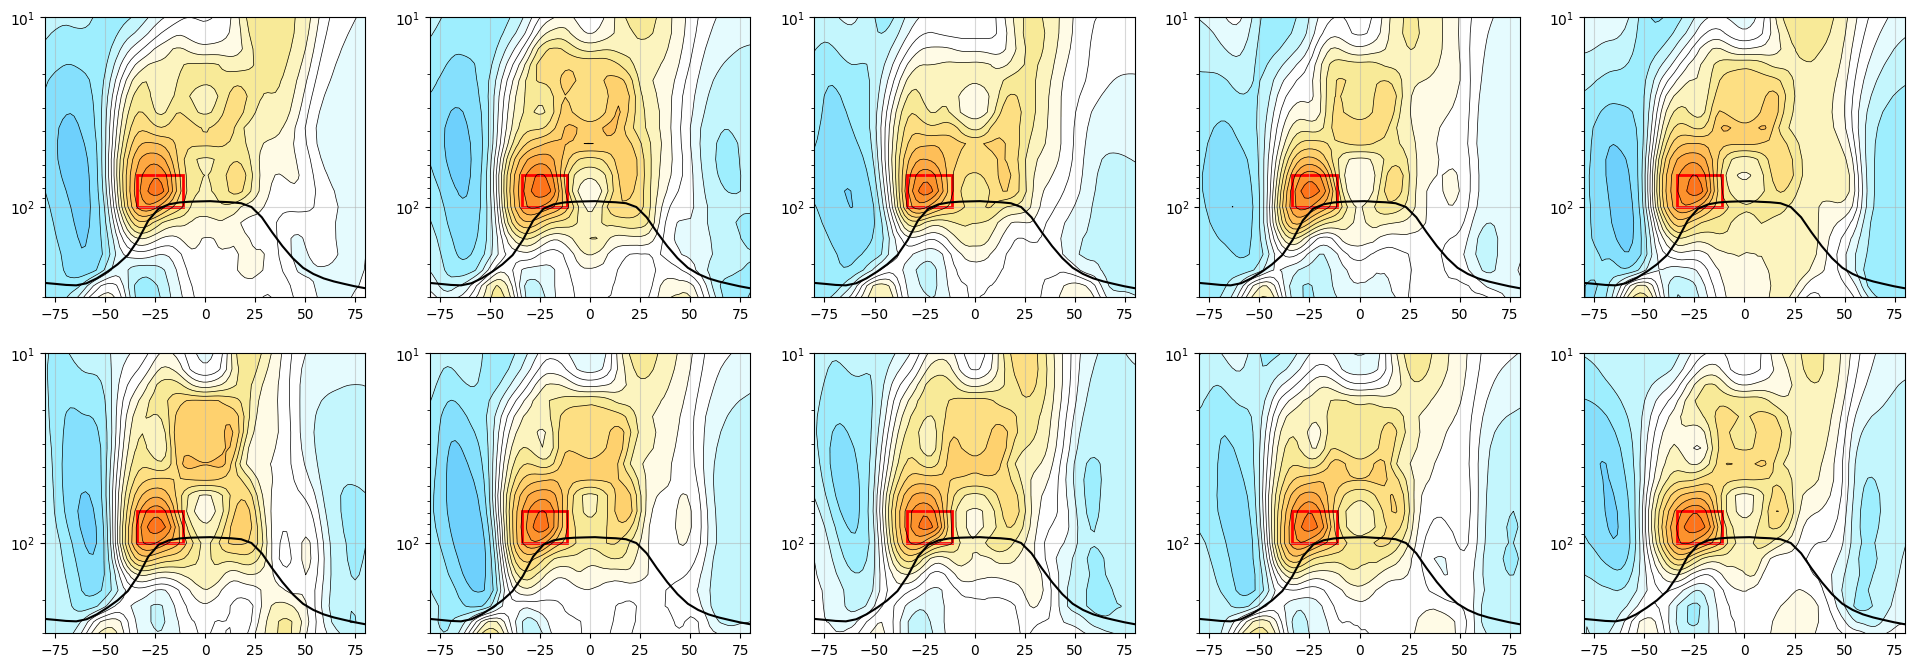

In [45]:
# set correlation levels
corr_levels = np.linspace(-1,1.0,21)


# create figure
fig, axs = plt.subplots(2,5, figsize=(24,8))
axes = axs.ravel()

for i in range(0, len(axes)):
    
    # set axes and correlation map to plot
    ax = axes[i]
    map_item = np.array(correlation_maps[i].T)
    
    # plot the trend
    ax.contour(lats, lev, map_item, levels=corr_levels, colors='black', extend='both', 
               linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    im = ax.contourf(lats, lev, map_item, levels=corr_levels, cmap=custom_cmap, extend='both')
    
    # add lapse rate tropopause and rectangle
    ax.plot(np.linspace(-90,90,36), lrp, color='black')
    rect = patches.Rectangle((-33.75, 68.), 22.5, 32, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # set plotting parameters
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_xlim(-80,80)
    ax.set_ylim(300,10)
    ax.grid(alpha=0.5)
    
#plt.savefig('/home/disk/p/aodhan/GNSSTrends/figures/WACCMTempAllEns.png', dpi=300)


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


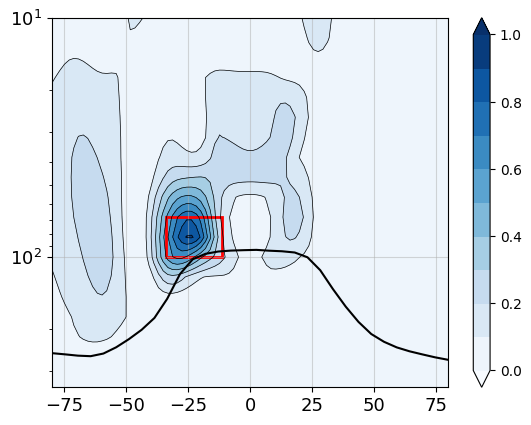

In [52]:
# set plot
fig, axs = plt.subplots(1,1)

# set r2 levels
r2_levels = np.arange(0,1.01,.1)

mean_r2_map = np.square(np.nanmean(correlation_maps, axis=0).T)

for i in range(0, len([axs])):
    
    # plot contour 
    axs.contour(lats, lev, mean_r2_map, levels=r2_levels, colors='black', extend='both', 
                linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    im = axs.contourf(lats, lev, mean_r2_map, levels=r2_levels,cmap='Blues', extend='both')
    
    # set lapse rate tropopause
    axs.plot(np.linspace(-90,90,36), lrp, color='black')
    rect = patches.Rectangle((-33.75, 68.), 22.5, 32, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    
    # set plotting parameters
    axs.set_yscale('log')
    axs.invert_yaxis()
    axs.set_xlim(-80,80)
    axs.set_ylim(350,10)
    axs.grid(alpha=0.5)
    cbar = plt.colorbar(im)
    x_vals = [-75, -50, -25, 0, 25, 50, 75]
    plt.xticks(x_vals)
    plt.tick_params(axis='both', which='major', labelsize=13)

# Get Monthly trends

In [18]:
# we only need the monthly trends, so we are going to use the circulation regression code,
# but input random value for the timeseries to preform regression with
filler_ts = np.random.rand(252)
jan  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 0)
feb  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 1)
mar  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 2)
apr  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 3)
may  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 4)
jun  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 5)
jul  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 6)
aug  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 7)
sep  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 8)
occ  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 9)
nov  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 10)
dec  = toolbox.monthly_circ_regr(ens_mean_anom, filler_ts, 11)


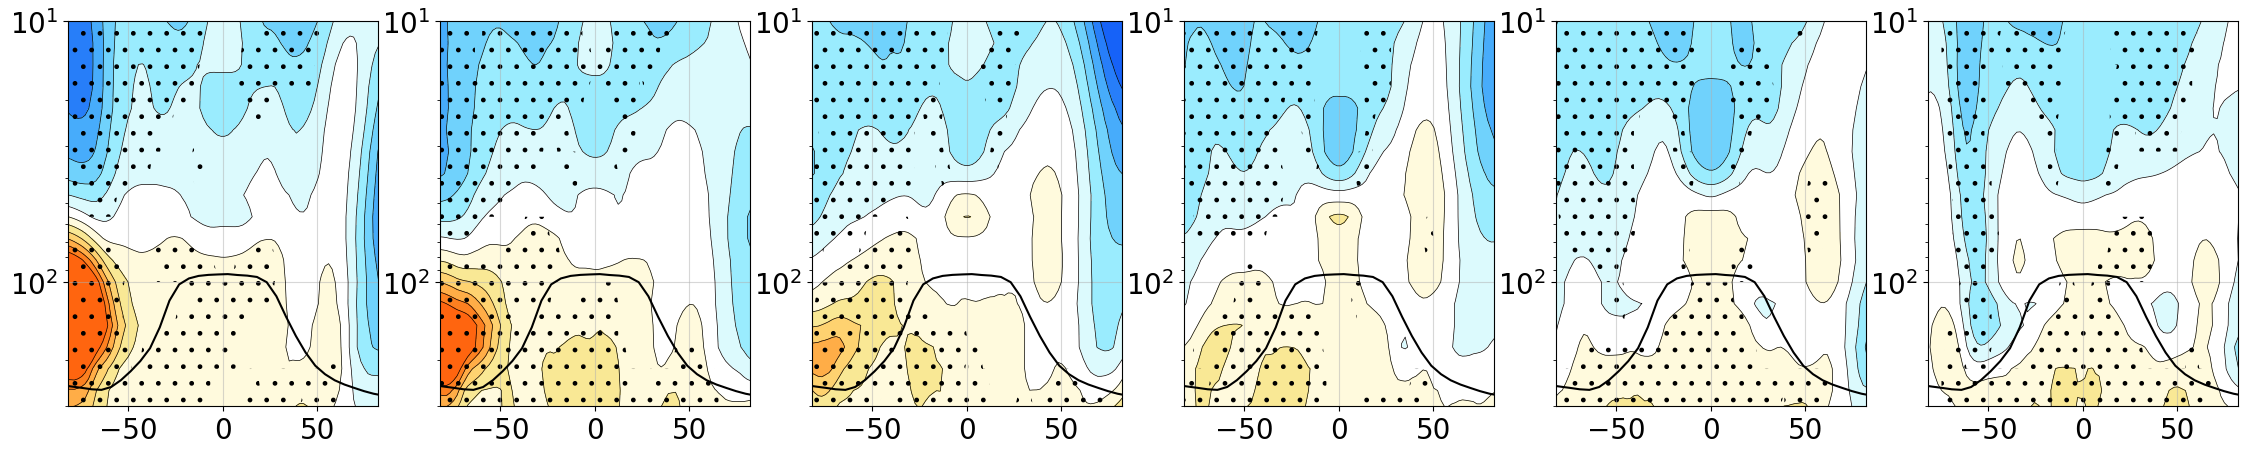

In [19]:
# define months
months1 = [jan, feb, mar, apr, may, jun]
#months2 = [jul, aug, sep, occ, nov, dec]

# choose months to plot
months = months1

# set plotting levels
levels = np.arange(-0.55,0.551,.1)*2

# create figure
fig, axs = plt.subplots(1,6, figsize=(28,5))
axes = axs.ravel()


for x in range(len(months1)):
    
    # plot contour
    axes[x].contour(lats, lev, months1[x][:,:,0,0], levels=levels, 
                    colors='black', extend='both', linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"))
    axes[x].contourf(lats, lev,  months1[x][:,:,0,0], levels=levels, 
                     cmap=custom_cmap, extend='both')
    
    # add significance and tropopause
    axes[x].contourf(lats, lev, months1[x][:,:,0,1], levels=[-1, 0, 1], 
                     colors='none', hatches=[None,'.'])
    axs[x].plot(np.linspace(-90,90,36), lrp, color='black')    
    
    # add plotting parameters
    axs[x].set_yscale('log')
    axs[x].invert_yaxis()
    axes[x].set_ylim(300,10)
    axes[x].set_xlim(-82,82)
    axes[x].grid(alpha=0.5)
    axes[x].tick_params(axis='both', which='major', labelsize=20)